### Deep learning with MXNet 

#### What is MXNet?

MXNet is a deep learning framework designed for both efficiency and flexibility.

The library is portable and lightweight, and it scales to multiple GPUs and multiple machines. 

Project’s GitHub: https://github.com/dmlc/mxnet

#### Why MXNet?

MXNet is a great tool for buidling neural nets and currently there are not many deep learning frameworks with GPU support you can use from R.

#### What this notebook is about?

In this notebook I'm going to show you how to build simple neural nets using MXNet. Instead of using well-known image datasets like MNIST, I will use data from financial domain to make task more intresting :)

First of all let's load some packages we will need for future work.

In [1]:
install.packages("drat", repos="https://cran.rstudio.com")
drat:::addRepo("dmlc")
install.packages("mxnet")


The downloaded binary packages are in
	/var/folders/qt/prymr5xs3xld425ggh5ym4wm0000gn/T//Rtmp9BoADU/downloaded_packages

The downloaded binary packages are in
	/var/folders/qt/prymr5xs3xld425ggh5ym4wm0000gn/T//Rtmp9BoADU/downloaded_packages


In [2]:
install.packages("DiagrammeRsvg")
install.packages("Metrics")
install.packages("ranger")
install.packages("caret")
install.packages("vtreat")


The downloaded binary packages are in
	/var/folders/qt/prymr5xs3xld425ggh5ym4wm0000gn/T//Rtmp9BoADU/downloaded_packages

The downloaded binary packages are in
	/var/folders/qt/prymr5xs3xld425ggh5ym4wm0000gn/T//Rtmp9BoADU/downloaded_packages

The downloaded binary packages are in
	/var/folders/qt/prymr5xs3xld425ggh5ym4wm0000gn/T//Rtmp9BoADU/downloaded_packages

The downloaded binary packages are in
	/var/folders/qt/prymr5xs3xld425ggh5ym4wm0000gn/T//Rtmp9BoADU/downloaded_packages

The downloaded binary packages are in
	/var/folders/qt/prymr5xs3xld425ggh5ym4wm0000gn/T//Rtmp9BoADU/downloaded_packages


In [3]:
require(mxnet) # for buidling Neural Nets 
require(vtreat)# for data preprocessing
require(ranger)# fast multi CPU random forest (our baseline model)
require(caret) # for train/test split
require(Metrics) #diffrent metrics (auc in our case)

Loading required package: mxnet
Loading required package: vtreat
Loading required package: ranger
Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2
Loading required package: Metrics


#### Dataset

Our dataset comes from UCI Machine Learning repository. Here is the [link](http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients).

The original format is .xls so I changed it to CSV by removing first row from the file and converting it to CSV.

Our goal will be to predict default of credit cards clients for the next month. A short data set description provided below:

Size: 30K rows, 23 features (3 categorical, 20 numeric)

* **default payment next month**: binary variable (Yes = 1, No = 0). 
* **LIMIT_BAL**: Amount of the given credit (NT dollar) 
* **SEX** : Gender (1 = male; 2 = female). 
* **EDUCATION** : Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
* **MARRIAGE** : Marital status (1 = married; 2 = single; 3 = others). 
* **AGE** : Age (in years). 
* **PAY_0 - PAY_6**: History of past payment (from April to September, 2005) in months, so -1 = pay duly, 1 = payment delay for one month;. . .; 9 = payment delay for nine months and above
* **BILL_AMT1 - BILL_AMT6** : Amount of bill statement (from April to September, 2005) 
* **PAY_AMT1 - PAY_AMT6** : Amount of previous payment (from April to September, 2005) 

We need convert 3 variabels to categorical (they encoded by integers), remove "ID" field and rename target variable.

In [4]:
setwd("~/Desktop/Data/UCI_CCdefaults")
dataset <- read.csv("default of credit card clients.csv")
#convert to categical
dataset$SEX <- as.factor(dataset$SEX)
dataset$EDUCATION <- as.factor(dataset$EDUCATION)
dataset$MARRIAGE <- as.factor(dataset$MARRIAGE)
#rename target variable
names(dataset)[names(dataset) == 'default.payment.next.month'] <- 'target'
#remove ID from data
dataset[,"ID"] <-NULL

We splitting data into train and validation(test) parts in order to be able chack model's performance. I'm using _createDataPartition()_ function from _[caret](http://topepo.github.io/caret/index.html)_ package.

In [5]:
set.seed(3456)
testIndex <- createDataPartition(as.factor(dataset$target), times = 1, p = 0.2, list = F)
dTrain <- dataset[-testIndex,]
dTest <- dataset[testIndex,]

#### Cleaning data and preparing it for MXNet

Data cleaning process can be vary difficult and time consuming, to avoid this I'm going to use vtreat package which does exactly what I need:

[vtreat](https://github.com/WinVector/vtreat) is an R data.frame processor/conditioner that prepares real-world data for predictive modeling in a statistically sound manner.

The library is designed to produce a 'data.frame' that is entirely numeric and takes common precautions to guard against the following real world data issues:
* Categorical variables with very many levels.
* Rare categorical levels.
* Novel categorical levels.
* Missing/invalid values NA, NaN, +/- Inf.
* Extreme values.
* Constant and near-constant variables.
* Need for estimated single-variable model effect sizes and significances.

In short: vtreat is AWESOME!!! 


In [6]:
yName <- 'target' # define target variable
yTarget <- 1 # define level to be considered "success"
varNames <- setdiff(names(dTrain),yName) # get variable names for vtreat

set.seed(8765)
treatmentsC <- designTreatmentsC(dTrain,varNames,yName,yTarget, verbose=FALSE)
dTrainTreated <- prepare(treatmentsC,dTrain,pruneSig=c(),scale=TRUE)
dTestTreated <- prepare(treatmentsC,dTest,pruneSig=c(),scale=TRUE)

MXNet allows you to monitor net performance during training process by using pre-defined or custom metrics. MXNet does not have logLoss metric in R package, so I added my own in order to be able track it.

In [7]:
mx.metric.mlogloss <- mx.metric.custom("mlogloss", function(label, pred){
    score <- -(label * log(pred) + (1 - label) * log(1 - pred))
    score[label == pred] <- 0
    score[is.nan(score)] <- Inf
    return(mean(score))
})

The easiest way to build neural net in MXNet is by using **_mx.mlp()_** function. Basically it's a wrapper which build multi-layer perceptron (MLP) for you. 

This function allows you to build MLP pretty much in the same way as H2O. YOu can define how many layers and how many neurons per layer you would like to have. You also can specify dropout rate for the _last_ layer (and only for the last layer) as well as many other things like optimizer, activations, evaluation metric, etc.

In our case I will build 4 layer MLP with 128 neurons for each layer, RELU will be our activation function. Adam will be an optimizer, we run our training process for 20 epochs using batch size of 256.

In [8]:
varNames <- setdiff(names(dTestTreated),yName) #get variables name for mx.mlp
mx.set.seed(1234) # set random seed, MXNet has its own!!!

model <- mx.mlp(data.matrix(dTrainTreated[,varNames]), # data
                dTrainTreated[,"target"], # target variable
                hidden_node=c(128,128,128,128), # number of hidden nodes per layer
                activation = "relu", # activation function, 
                                     # can be a vector as well, 
                                     # like c("relu","tanh", "tanh")
                out_node=1, # output node, 1 in our case (binary classification)
                out_activation="logistic", # can be "rmse" for regression 
                                           # or "softmax" for multiclassification
                optimizer = "adam", # "sgd" by default, 
                                    # can be "rmsprop", "adagrad", "adadelta"
                num.round=20, # number of epochs
                array.batch.size=256, # batch size
                learning.rate=0.01, # learning rate
                device = mx.cpu(), # uses mx.cpu() by default, can use mx.gpu() for CUDA-enabled GPU
                eval.metric=mx.metric.mlogloss, # LogLoss as evaluation metric
                verbose = T, array.layout = "rowmajor")

Start training with 1 devices
[1] Train-mlogloss=0.484432607020532
[2] Train-mlogloss=0.450422443085471
[3] Train-mlogloss=0.444419767648091
[4] Train-mlogloss=0.439558608846886
[5] Train-mlogloss=0.437309859477733
[6] Train-mlogloss=0.434940793689841
[7] Train-mlogloss=0.433230154347481
[8] Train-mlogloss=0.431733996033972
[9] Train-mlogloss=0.430648501011328
[10] Train-mlogloss=0.430082955654967
[11] Train-mlogloss=0.42899153209709
[12] Train-mlogloss=0.427946614787315
[13] Train-mlogloss=0.427722135995491
[14] Train-mlogloss=0.42743837289673
[15] Train-mlogloss=0.427052213552287
[16] Train-mlogloss=0.426828598140015
[17] Train-mlogloss=0.42695100514335
[18] Train-mlogloss=0.426270963319918
[19] Train-mlogloss=0.425710349060679
[20] Train-mlogloss=0.425194091092481


We can visualize our net 


_Note, from RStudio you just need to execute this command:_
```S
graph.viz(model$symbol$as.json(),graph.title.font.size = 15)
```
_The rest is just an attempt to visualize network in Jupyter Notebook_

In [9]:
IRdisplay::display_html(DiagrammeRsvg::export_svg(graph.viz(model$symbol$as.json(),graph.title.font.size = 15)))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: %3 Pages: 1 -->
 
 
 %3 
 
 Computation graph 
<!-- 0 -->
 0 
 
 data 
 
<!-- 3 -->
 3 
 
 FullyConnected 
 128 
 
<!-- 0->3 -->
 0->3 
 
 
 
<!-- 4 -->
 4 
 
 Activation 
 relu 
 
<!-- 3->4 -->
 3->4 
 
 
 
<!-- 7 -->
 7 
 
 FullyConnected 
 128 
 
<!-- 4->7 -->
 4->7 
 
 
 
<!-- 8 -->
 8 
 
 Activation 
 relu 
 
<!-- 7->8 -->
 7->8 
 
 
 
<!-- 11 -->
 11 
 
 FullyConnected 
 128 
 
<!-- 8->11 -->
 8->11 
 
 
 
<!-- 12 -->
 12 
 
 Activation 
 relu 
 
<!-- 11->12 -->
 11->12 
 
 
 
<!-- 15 -->
 15 
 
 FullyConnected 
 128 
 
<!-- 12->15 -->
 12->15 
 
 
 
<!-- 16 -->
 16 
 
 Activation 
 relu 
 
<!-- 15->16 -->
 15->16 
 
 
 
<!-- 19 -->
 19 
 
 FullyConnected 
 1 
 
<!-- 16->19 -->
 16->19 
 
 
 
<!-- 21 -->
 21 
 
 logisticregressionoutput0 
 
<!-- 19->21 -->
 19->21

pre-main prep time: 1 ms


Now we have a trained neural net (MLP) and we can validate it's performance on test set.

In [10]:
preds = t(predict(model, data.matrix(dTestTreated[,varNames]), 
                  array.layout = "rowmajor"))
auc_nn <- auc(dTestTreated[,"target"], preds[,1])
logloss_nn <-logLoss(dTestTreated[,"target"], preds[,1])

As a baseline model I'm going to use random forest with 500 trees from _[ranger](https://cran.r-project.org/web/packages/ranger/index.html)_ package.

In [11]:
set.seed(42)
rf <- ranger(as.factor(target) ~., data = dTrain, probability = T)
rf_preds <- predict(rf, dTest)$predictions
auc_rf <- auc(dTestTreated[,"target"], rf_preds[,2])
logloss_rf <- logLoss(dTestTreated[,"target"], rf_preds[,2])

In [12]:
results <- data.frame(model = "MXNet ver 1.0 using mx.mlp", logloss = logloss_nn, AUC = auc_nn)
results <- rbind(results, data.frame(model = "Baseline (randomForest)", logloss = logloss_rf, AUC = auc_rf))
results[order(as.character(results$model)),]

,model,logloss,AUC
2,Baseline (randomForest),0.4318725,0.7770181
1,MXNet ver 1.0 using mx.mlp,0.4332011,0.7832295


As you can see our model does pretty good compare to a baseline. It was able to produce better AUC score but worse logloss.

#### Building your own net

As you might notice by using ***mx.mlp()*** we having a lot of limitations, like we can't using dropout for any layer except the last one. Also there is no way to add some additional layers (like BatchNorm, always wanted do to that for MLP).

If we need the full flexibility we can think of neural net as some sort of connected graph. And MXNet allows you to build such graph by youself. Lewt's try to build the very same network using symbolic capabilities of MXNet.

In [13]:
data <- mx.symbol.Variable('data')
fc1  <- mx.symbol.FullyConnected(data = data, name = 'fc1', num_hidden = 128)
act1 <- mx.symbol.Activation(data = fc1, name = 'relu1', act_type = "relu")

fc2  <- mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 128)
act2 <- mx.symbol.Activation(data = fc2, name = 'relu2', act_type = "relu")

fc3 <- mx.symbol.FullyConnected(data = act2, name = 'fc3', num_hidden = 128)
act3 <- mx.symbol.Activation(data = fc3, name = 'relu3', act_type = "relu")

fc4  <- mx.symbol.FullyConnected(data = act3, name = 'fc4', num_hidden = 128)
act4 <- mx.symbol.Activation(data = fc4, name = 'relu4', act_type = "relu")

fc5  <- mx.symbol.FullyConnected(data = act4, name = 'fc5', num_hidden = 1)
mlp2  <- mx.symbol.LogisticRegressionOutput(data = fc5, name = 'logistic')

After we define the graph we need to run training process with help of ***FeedForward.create()*** function.

In [14]:
mx.set.seed(1234)
model2 <- mx.model.FeedForward.create(
  X                 = data.matrix(dTrainTreated[,varNames]),
  y                 = dTrainTreated[,"target"],
  optimizer         = "adam",
  ctx               = mx.cpu(),
  symbol            = mlp2,
  eval.metric       = mx.metric.mlogloss,
  num.round         = 20,
  learning.rate     = 0.01,
  array.batch.size  = 256,
  verbose = T, array.layout = "rowmajor"
)

Start training with 1 devices
[1] Train-mlogloss=0.484432607020532
[2] Train-mlogloss=0.450422443085471
[3] Train-mlogloss=0.444419767648091
[4] Train-mlogloss=0.439558608846886
[5] Train-mlogloss=0.437309859477733
[6] Train-mlogloss=0.434940793689841
[7] Train-mlogloss=0.433230154347481
[8] Train-mlogloss=0.431733996033972
[9] Train-mlogloss=0.430648501011328
[10] Train-mlogloss=0.430082955654967
[11] Train-mlogloss=0.42899153209709
[12] Train-mlogloss=0.427946614787315
[13] Train-mlogloss=0.427722135995491
[14] Train-mlogloss=0.42743837289673
[15] Train-mlogloss=0.427052213552287
[16] Train-mlogloss=0.426828598140015
[17] Train-mlogloss=0.42695100514335
[18] Train-mlogloss=0.426270963319918
[19] Train-mlogloss=0.425710349060679
[20] Train-mlogloss=0.425194091092481


If I visualize this net you will see that it's completely the same as net generated by *mx.mlp()*

In [15]:
IRdisplay::display_html(DiagrammeRsvg::export_svg(graph.viz(model2$symbol$as.json(),graph.title.font.size = 15)))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: %3 Pages: 1 -->
 
 
 %3 
 
 Computation graph 
<!-- 0 -->
 0 
 
 data 
 
<!-- 3 -->
 3 
 
 FullyConnected 
 128 
 
<!-- 0->3 -->
 0->3 
 
 
 
<!-- 4 -->
 4 
 
 Activation 
 relu 
 
<!-- 3->4 -->
 3->4 
 
 
 
<!-- 7 -->
 7 
 
 FullyConnected 
 128 
 
<!-- 4->7 -->
 4->7 
 
 
 
<!-- 8 -->
 8 
 
 Activation 
 relu 
 
<!-- 7->8 -->
 7->8 
 
 
 
<!-- 11 -->
 11 
 
 FullyConnected 
 128 
 
<!-- 8->11 -->
 8->11 
 
 
 
<!-- 12 -->
 12 
 
 Activation 
 relu 
 
<!-- 11->12 -->
 11->12 
 
 
 
<!-- 15 -->
 15 
 
 FullyConnected 
 128 
 
<!-- 12->15 -->
 12->15 
 
 
 
<!-- 16 -->
 16 
 
 Activation 
 relu 
 
<!-- 15->16 -->
 15->16 
 
 
 
<!-- 19 -->
 19 
 
 FullyConnected 
 1 
 
<!-- 16->19 -->
 16->19 
 
 
 
<!-- 21 -->
 21 
 
 logistic 
 
<!-- 19->21 -->
 19->21

pre-main prep time: 0 ms


Let's check it's performance

In [16]:
preds2 = t(predict(model2, data.matrix(dTestTreated[,varNames]), 
                  array.layout = "rowmajor"))
auc_nn2 <- auc(dTestTreated[,"target"], preds[,1])
logloss_nn2 <-logLoss(dTestTreated[,"target"], preds[,1])

In [17]:
results <- rbind(results, data.frame(model = "MXNet ver 1.0 using graph", logloss = logloss_nn2, AUC = auc_nn2))
results[order(as.character(results$model)),]

,model,logloss,AUC
2,Baseline (randomForest),0.4318725,0.7770181
3,MXNet ver 1.0 using graph,0.4332011,0.7832295
1,MXNet ver 1.0 using mx.mlp,0.4332011,0.7832295


Yep, results are completely the same

Now, let's constract something interesting using this approach.

I'm reducing amount of fully-connected layers from 4 to 2.

Adding dropout after input layer with a relatevely small probability value, sometimes it might be helpful if input is noisy. 

Also, I always wanted to use BatchNorm for MLP, so I'm adding a BatchNorm layer after each fully connected but before activation layer. To learn more about Batch normalization use this [link](https://www.quora.com/Why-does-batch-normalization-help)

And the last thing let's connect our fully connected layers in some fancy fashion :) I'm going to use ResNet-like approach for that. Have no idea how it is going to work and odes it make any sense. Basically I'm also connecting output of activation layer 1 with output of fully-connected layer 2 via sum operation. 

In [18]:
data <- mx.symbol.Variable('data')
dr0 = mx.symbol.Dropout(data = data, p = 0.1)
fc1  <- mx.symbol.FullyConnected(data = dr0, name = 'fc1', num_hidden = 128)
bn1 <- mx.symbol.BatchNorm(data = fc1, name = 'bn1')
act1 <- mx.symbol.Activation(data = bn1, name = 'relu1', act_type = "relu")

fc2 <- mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 128)
resid <- act1 + fc2
bn2 <- mx.symbol.BatchNorm(data = resid, name = 'bn2')
act2 <- mx.symbol.Activation(data = bn2, name = 'relu2', act_type = "relu")

dr1 = mx.symbol.Dropout(data = act2, p = 0.5)
fc3  <- mx.symbol.FullyConnected(data = dr1, name = 'fc3', num_hidden = 1)
mlp3  <- mx.symbol.LogisticRegressionOutput(data = fc3, name = 'logistic')

Train our new model

In [19]:
mx.set.seed(1234)
model3 <- mx.model.FeedForward.create(
  X                 = data.matrix(dTrainTreated[,varNames]),
  y                 = dTrainTreated[,"target"],
  initializer = mx.init.uniform(0.01),
  array.layout = "rowmajor",
  optimizer = "adam",
  ctx                = mx.cpu(),
  symbol             = mlp3,
  eval.metric        = mx.metric.mlogloss,
  num.round          = 20,
  learning.rate      = 0.01,
  array.batch.size   = 256,
  verbose = T
)

Start training with 1 devices
[1] Train-mlogloss=0.461843923579264
[2] Train-mlogloss=0.448860052886505
[3] Train-mlogloss=0.445368511766574
[4] Train-mlogloss=0.444801046262184
[5] Train-mlogloss=0.443465393225882
[6] Train-mlogloss=0.442632714927177
[7] Train-mlogloss=0.442063168128457
[8] Train-mlogloss=0.440379944156467
[9] Train-mlogloss=0.439795547163999
[10] Train-mlogloss=0.440374455696086
[11] Train-mlogloss=0.437733539743392
[12] Train-mlogloss=0.435790743747493
[13] Train-mlogloss=0.436919547500027
[14] Train-mlogloss=0.43663233656735
[15] Train-mlogloss=0.438787030385001
[16] Train-mlogloss=0.435706863462959
[17] Train-mlogloss=0.435756255628331
[18] Train-mlogloss=0.435729597216346
[19] Train-mlogloss=0.435499953242892
[20] Train-mlogloss=0.434456923363966


Display it.

In [20]:
IRdisplay::display_html(DiagrammeRsvg::export_svg(graph.viz(model3$symbol$as.json(),graph.title.font.size = 15)))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: %3 Pages: 1 -->
 
 
 %3 
 
 Computation graph 
<!-- 0 -->
 0 
 
 data 
 
<!-- 1 -->
 1 
 
 Dropout 
 
<!-- 0->1 -->
 0->1 
 
 
 
<!-- 4 -->
 4 
 
 FullyConnected 
 128 
 
<!-- 1->4 -->
 1->4 
 
 
 
<!-- 7 -->
 7 
 
 BatchNorm 
 
<!-- 4->7 -->
 4->7 
 
 
 
<!-- 8 -->
 8 
 
 Activation 
 relu 
 
<!-- 7->8 -->
 7->8 
 
 
 
<!-- 11 -->
 11 
 
 FullyConnected 
 128 
 
<!-- 8->11 -->
 8->11 
 
 
 
<!-- 12 -->
 12 
 
 _Plus 
 
<!-- 8->12 -->
 8->12 
 
 
 
<!-- 11->12 -->
 11->12 
 
 
 
<!-- 15 -->
 15 
 
 BatchNorm 
 
<!-- 12->15 -->
 12->15 
 
 
 
<!-- 16 -->
 16 
 
 Activation 
 relu 
 
<!-- 15->16 -->
 15->16 
 
 
 
<!-- 17 -->
 17 
 
 Dropout 
 
<!-- 16->17 -->
 16->17 
 
 
 
<!-- 20 -->
 20 
 
 FullyConnected 
 1 
 
<!-- 17->20 -->
 17->20 
 
 
 
<!-- 22 -->
 22 
 
 logistic 
 
<!-- 20->22 -->
 20->22

pre-main prep time: 1 ms


Check model's performance using validation dataset

In [21]:
preds = predict(model3, data.matrix(dTestTreated[,varNames]), array.layout = "rowmajor")
preds <- t(preds)
auc_nn3 <- auc(dTestTreated[,"target"], preds[,1])
logloss_nn3 <-logLoss(dTestTreated[,"target"], preds[,1])

In [22]:
results <- rbind(results, data.frame(model = "MXNet ver 2.0", logloss = logloss_nn3, AUC = auc_nn3))
results[order(as.character(results$model)),]

,model,logloss,AUC
2,Baseline (randomForest),0.4318725,0.7770181
3,MXNet ver 1.0 using graph,0.4332011,0.7832295
1,MXNet ver 1.0 using mx.mlp,0.4332011,0.7832295
4,MXNet ver 2.0,0.4291513,0.7875946


As you can see our second version of the model doing better than baseline and version 1, despite being simpler model in terms of neurons and layers.

As the last step I'm going to run 5-fold cross-validation  for 5 times to check models performance.

In [23]:
set.seed(3456)
folds <- createMultiFolds(as.factor(dataset$target), k = 5, times = 5)
cv_results <- data.frame()

In [26]:
for(fold in folds) {
  #splitting dataset into train and validation
  trainIndex <- fold
  dTrain <- dataset[trainIndex,]
  dTest <- dataset[-trainIndex,]
  
  yName <- 'target' # define target variable
  yTarget <- 1 # define level to be considered "success"
  varNames <- setdiff(names(dTrain),yName) # get variable names for vtreat
  
  treatmentsC <- designTreatmentsC(dTrain,varNames,yName,yTarget, verbose=FALSE)
  dTrainTreated <- prepare(treatmentsC,dTrain,pruneSig=c(),scale=TRUE)
  dTestTreated <- prepare(treatmentsC,dTest,pruneSig=c(),scale=TRUE)

  varNames <- setdiff(names(dTestTreated),yName)
  
  mx.set.seed(1234)
  model <- mx.model.FeedForward.create(
    X                 = data.matrix(dTrainTreated[,varNames]),
    y                 = dTrainTreated[,"target"],
    initializer = mx.init.uniform(0.01),
    array.layout = "rowmajor",
    optimizer = "adam",
    ctx                = mx.cpu(),
    symbol             = mlp3,
    eval.metric        = mx.metric.mlogloss,
    num.round          = 20,
    learning.rate      = 0.01,
    array.batch.size   = 256,
    verbose = F
  )
  
  preds = predict(model, data.matrix(dTestTreated[,varNames]), array.layout = "rowmajor")
  preds <- t(preds)
  auc_nn <- auc(dTestTreated[,"target"], preds[,1])
  logloss_nn <-logLoss(dTestTreated[,"target"], preds[,1])
  
  mx.set.seed(1234)
  model_mlp <- mx.model.FeedForward.create(
    X                 = data.matrix(dTrainTreated[,varNames]),
    y                 = dTrainTreated[,"target"],
    initializer = mx.init.uniform(0.01),
    array.layout = "rowmajor",
    optimizer = "adam",
    ctx                = mx.cpu(),
    symbol             = mlp2,
    eval.metric        = mx.metric.mlogloss,
    num.round          = 20,
    learning.rate      = 0.01,
    array.batch.size   = 256,
    verbose = F
  )

  preds_mlp = predict(model_mlp, data.matrix(dTestTreated[,varNames]), array.layout = "rowmajor")
  preds_mlp <- t(preds_mlp)
  auc_mlp <- auc(dTestTreated[,"target"], preds_mlp[,1])
  logloss_mlp <-logLoss(dTestTreated[,"target"], preds_mlp[,1])
  
  set.seed(42)
  rf <- ranger(as.factor(target) ~., data = dTrain, probability = T)
  rf_preds <- predict(rf, dTest)$predictions
  auc_rf <- auc(dTestTreated[,"target"], rf_preds[,2])
  logloss_rf <- logLoss(dTestTreated[,"target"], rf_preds[,2])
  cv_results <- rbind(
    cv_results, 
    data.frame(model = "MXnet ver 1", logloss = logloss_mlp, auc = auc_mlp),
    data.frame(model = "MXnet ver 2", logloss = logloss_nn, auc = auc_nn),
    data.frame(model = "RandomForest", logloss = logloss_rf, auc = auc_rf))
}

Let's plot our models performance using boxplot

Loading required package: reshape2
Using model as id variables


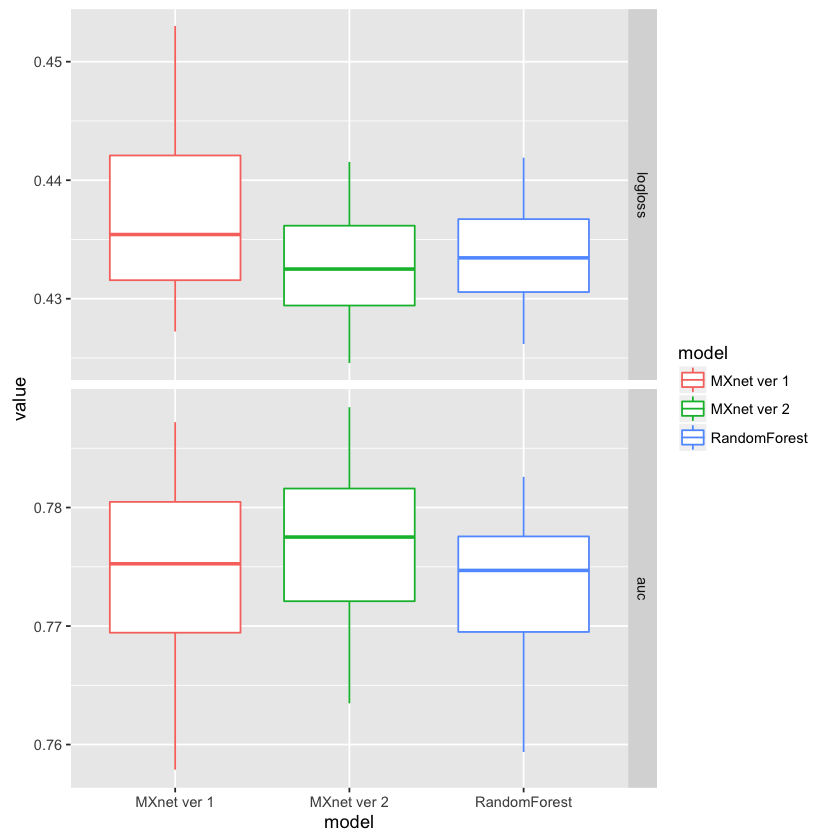

In [27]:
require(ggplot2)
require(reshape2)
p <- ggplot(melt(cv_results), aes(x=model, y=value, colour=model)) + 
  geom_boxplot(outlier.colour="red", outlier.shape=8,
               outlier.size=4)
p + facet_grid("variable~.", scales = "free", space = "free")

#### Summary

In this notebook a bacis priciples of building neural nets using MXNet were shown. 

vtreat+MXNet approach was introduced for using neural nets for structured data. 

I hope you found this notebook (or part of it) helpful :)

Code available on GitHub: https://github.com/IzuiT/H2O_Dallas_MXNet